# Load Dataset

In [7]:
import pandas as pd
import os
import numpy as np
from pprint import pprint
from pathlib import Path
import itertools

In [23]:
def tryconvert(x, to_type, default):
  '''
  Try convert `x` to a type specified by `to_type` function. 
  Returns `default` value if casting is not possibile 
  '''
  try:
    return to_type(x)
  except:
    return default

def load_data(directory, nrows=None, usecols=None, converters=None, dtype=None):
# Read each CSV file in dir "path/to/root_dir"
    dfs = []
    for file in Path(directory).glob('**/*.csv'):
        dfs.append(pd.read_csv(file, nrows=nrows, usecols=usecols, converters=converters, dtype=dtype))
    # Put the dataframes to a single dataframe
    df = pd.concat(dfs, ignore_index=True)
    return df

benign_dir = os.path.join(os.getcwd(), 'dataset', 'Benign')
malware_dir = os.path.join(os.getcwd(), 'dataset', 'Malware')

usecols = [" Total Length of Bwd Packets", " Fwd Packet Length Std", " Bwd Packet Length Min", " Bwd Packet Length Std", " Flow IAT Mean", " Flow IAT Min", "Init_Win_bytes_forward", " Init_Win_bytes_backward", " min_seg_size_forward", " Label"]

# Define column datatype when reading CSVs
converters = dict(itertools.product(usecols, [lambda x: tryconvert(x, float, np.nan)]))
converters[" Label"] = lambda x: x

benign_df = load_data(benign_dir, nrows=None, usecols=usecols, converters=converters)
malware_df = load_data(malware_dir, nrows=None, usecols=usecols, converters=converters)

df = pd.concat([benign_df, malware_df], ignore_index=True)

# shuffle dataset
#df = df.sample(frac=1).reset_index(drop=True)

# trim columns labels
df.columns = df.columns.str.strip()

# Drop rows which contain NaN values
df.dropna(inplace=True)

# Drop empty label rows
df.drop(df[df["Label"] == ''].index, inplace = True)

# Change Label values in "MALWARE" or "BENIGN"
df["Label"] = df["Label"].apply(lambda x: 'MALWARE' if x != 'BENIGN' else x)
df

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Label
0,170.0,231.517458,0.0,85.0,35088.833333,25.0,65535.0,16.0,32.0,BENIGN
1,0.0,0.000000,0.0,0.0,142284.000000,142284.0,1386.0,-1.0,32.0,BENIGN
2,0.0,0.000000,0.0,0.0,18765.000000,716.0,2290.0,426.0,32.0,BENIGN
3,0.0,0.000000,0.0,0.0,18369.500000,27.0,1419.0,362.0,32.0,BENIGN
4,0.0,0.000000,0.0,0.0,289279.000000,289279.0,1641.0,-1.0,32.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...
2192427,50.0,0.000000,50.0,0.0,50437.000000,50437.0,-1.0,-1.0,32.0,MALWARE
2192428,166.0,0.000000,166.0,0.0,48506.000000,48506.0,-1.0,-1.0,32.0,MALWARE
2192429,172.0,0.000000,172.0,0.0,569717.000000,569717.0,-1.0,-1.0,40.0,MALWARE
2192430,17.0,0.000000,17.0,0.0,97804.000000,97804.0,-1.0,-1.0,32.0,MALWARE


In [24]:
df.shape

(2192421, 10)

<AxesSubplot: xlabel='Label', ylabel='# occurrences'>

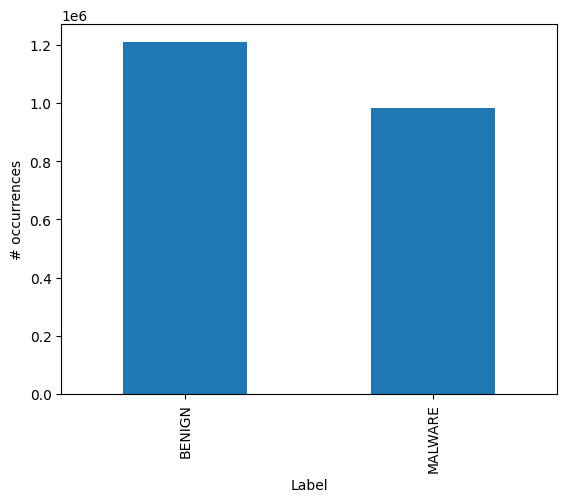

In [25]:
df["Label"].value_counts().plot(
    kind="bar",
    xlabel="Label",
    ylabel="# occurrences"
)

# Data Preprocessing

In [26]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def data_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    if "Source IP" in df.columns:
        df['Source IP'] = label_encoder.fit_transform(df['Source IP'])
    if "Flow ID" in df.columns:
        df['Flow ID'] = label_encoder.fit_transform(df['Flow ID'])
    if "Destination IP" in df.columns:
        df['Destination IP'] = label_encoder.fit_transform(df['Destination IP'])

    if "Timestamp" in df.columns:
        # drop column Timestamp
        df = df.drop(['Timestamp'], axis=1)    
    return df

df = data_preprocessing(df)
df.shape

(2192421, 10)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Label'], axis=1),
    df['Label'],
    test_size=0.4,
    random_state=42
)

X_train.shape, X_test.shape

((1315452, 9), (876969, 9))

In [16]:
X_train.head()

,Total Length of Bwd Packets,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Mean,Flow IAT Min,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward
606964,0.0,0.000000,0.0,0.000000,8.009585e+06,8009585.0,1423.0,-1.0,32.0
2065209,0.0,0.000000,0.0,0.000000,2.055000e+03,2055.0,29.0,1369.0,20.0
2072321,1669.0,336.653969,0.0,104.984794,2.861907e+06,41.0,65535.0,400.0,32.0
1932879,0.0,0.000000,0.0,0.000000,2.309500e+04,23095.0,1415.0,-1.0,20.0
484794,0.0,0.000000,0.0,0.000000,2.335950e+04,11346.0,672.0,1458.0,32.0


In [17]:
y_train.head()

606964      BENIGN
2065209    MALWARE
2072321    MALWARE
1932879    MALWARE
484794      BENIGN
Name: Label, dtype: object

# Valutazione

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test):
    y_pred = clf.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title='Confusion matrix')


# Decision Tree

In [16]:
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)

[Text(0.5, 0.875, 'Init_Win_bytes_forward <= 29.5\ngini = 0.339\nsamples = 823961\nvalue = [645631, 178330]\nclass = BENIGN'),
 Text(0.25, 0.625, 'Flow IAT Mean <= 3599777.0\ngini = 0.098\nsamples = 133717\nvalue = [126803, 6914]\nclass = BENIGN'),
 Text(0.125, 0.375, 'Total Length of Bwd Packets <= 31.5\ngini = 0.072\nsamples = 125770\nvalue = [121080, 4690]\nclass = BENIGN'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'min_seg_size_forward <= 23.0\ngini = 0.403\nsamples = 7947\nvalue = [5723, 2224]\nclass = BENIGN'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Init_Win_bytes_forward <= 1023.5\ngini = 0.373\nsamples = 690244\nvalue = [518828, 171416]\nclass = BENIGN'),
 Text(0.625, 0.375, 'Init_Win_bytes_backward <= 346.5\ngini = 0.31\nsamples = 132790\nvalue = [107362, 25428]\nclass = BENIGN'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text

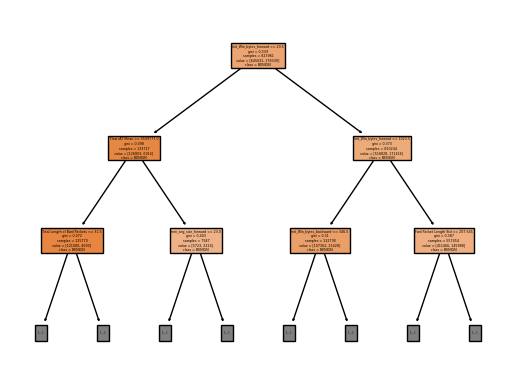

In [17]:
tree.plot_tree(decision_tree, filled=True, class_names=decision_tree.classes_, feature_names=X_train.columns, max_depth=2)

              precision    recall  f1-score   support

      BENIGN       0.86      0.85      0.86    429833
     MALWARE       0.48      0.51      0.49    119475

    accuracy                           0.78    549308
   macro avg       0.67      0.68      0.68    549308
weighted avg       0.78      0.78      0.78    549308



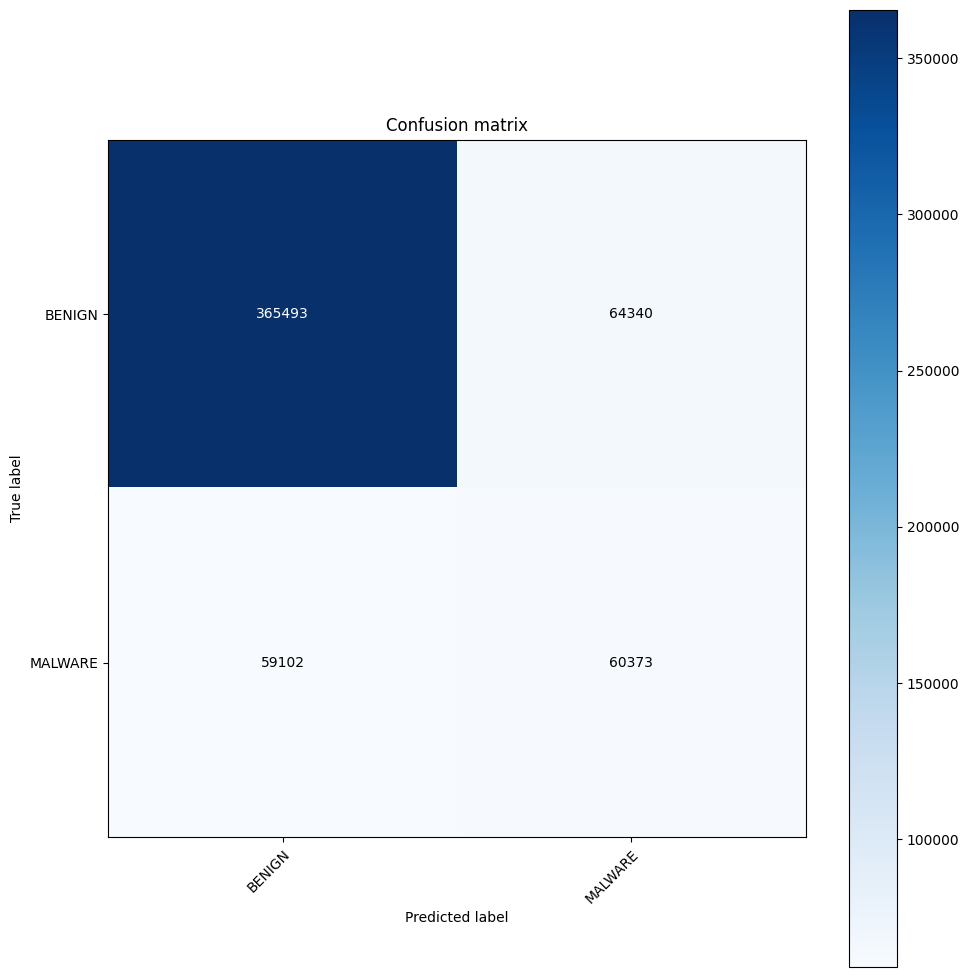

In [18]:
valuate(decision_tree, X_test, y_test)

In [19]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    decision_tree,
    X_train,
    y_train,
    cv=10,
    scoring=['precision_macro', 'recall_macro']
)

In [ ]:
print(f'{10}-fold cross validation:')
print('Precision: %0.2f (+/- %0.2f)' % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print('Recall: %0.2f (+/- %0.2f)' % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))

10-fold cross validation:
Precision: 0.75 (+/- 0.01)
Recall: 0.75 (+/- 0.00)


# KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

              precision    recall  f1-score   support

      BENIGN       0.62      0.66      0.64    484144
     MALWARE       0.55      0.51      0.53    391694

    accuracy                           0.59    875838
   macro avg       0.59      0.58      0.58    875838
weighted avg       0.59      0.59      0.59    875838



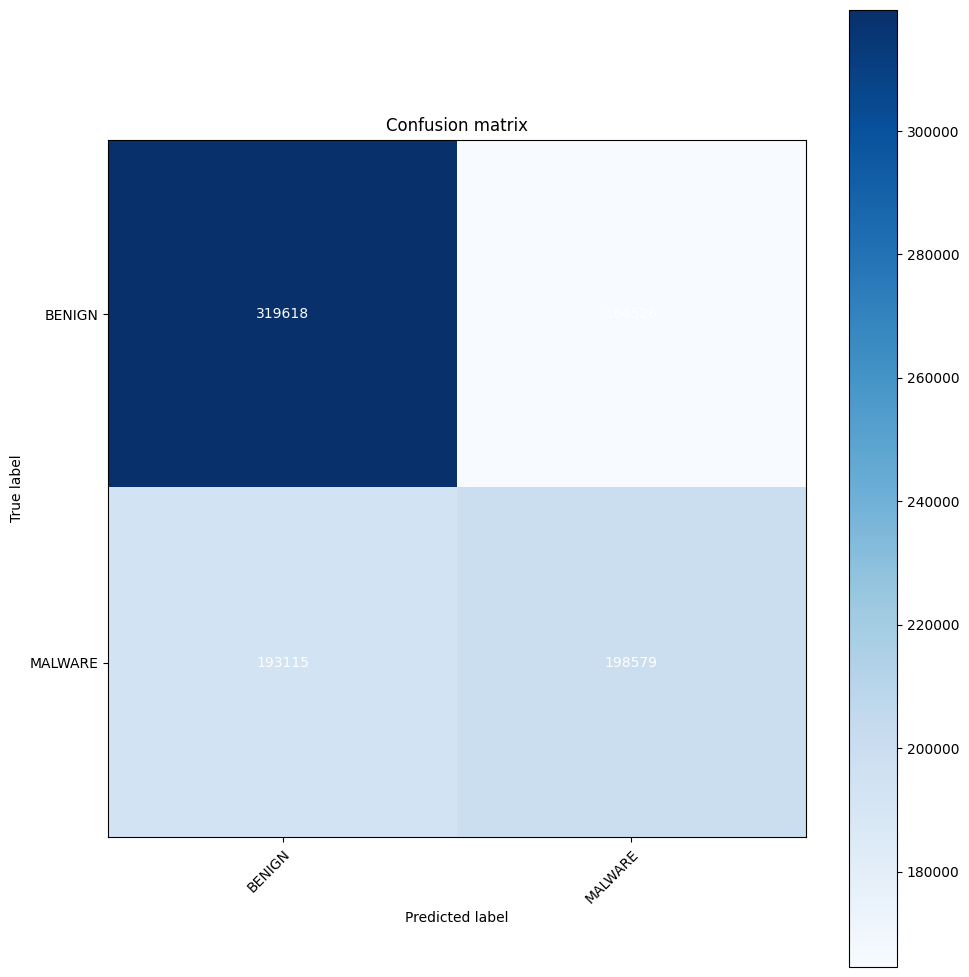

In [30]:
valuate(knn, X_test, y_test)

# Support Vector Machine

In [31]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

C=1.0
models = (
    # svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=1000, dual=True),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    #svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = [clf.fit(X_train, y_train) for clf in models]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC:
              precision    recall  f1-score   support

      BENIGN       0.57      0.31      0.40      2311
     MALWARE       0.42      0.69      0.52      1689

    accuracy                           0.47      4000
   macro avg       0.50      0.50      0.46      4000
weighted avg       0.51      0.47      0.45      4000

SVC:
              precision    recall  f1-score   support

      BENIGN       0.58      1.00      0.73      2311
     MALWARE       1.00      0.01      0.02      1689

    accuracy                           0.58      4000
   macro avg       0.79      0.51      0.38      4000
weighted avg       0.76      0.58      0.43      4000



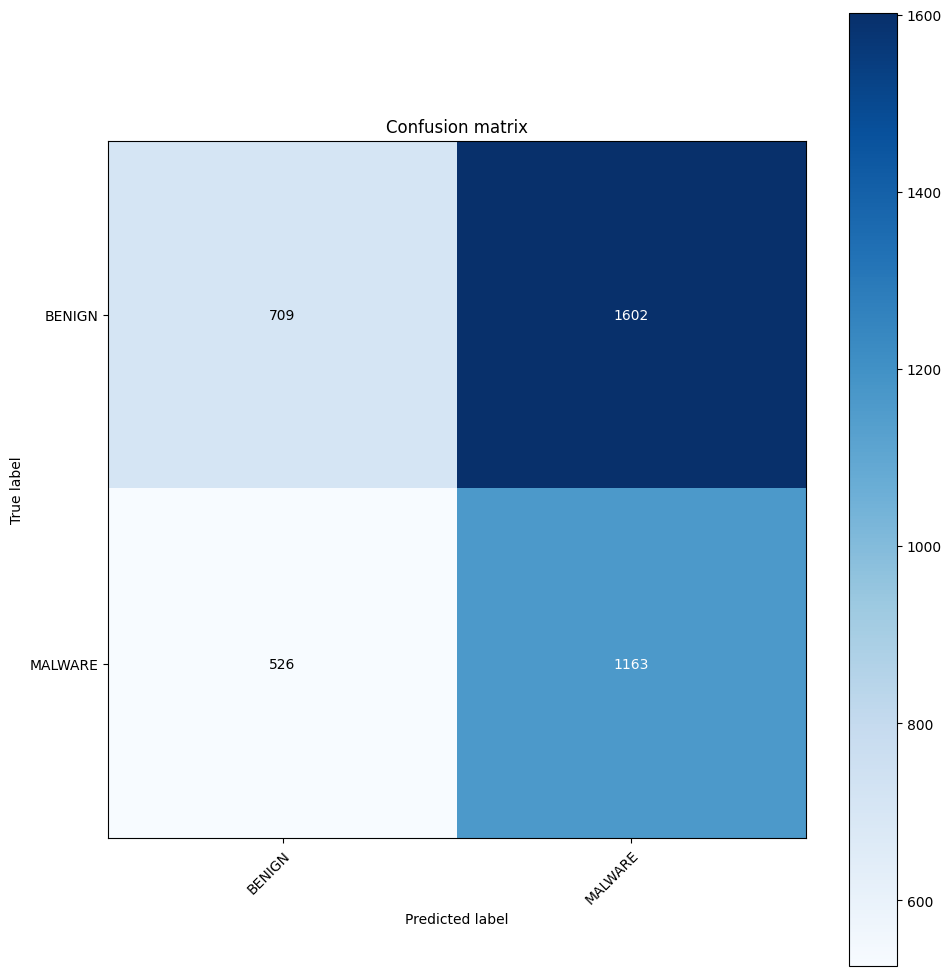

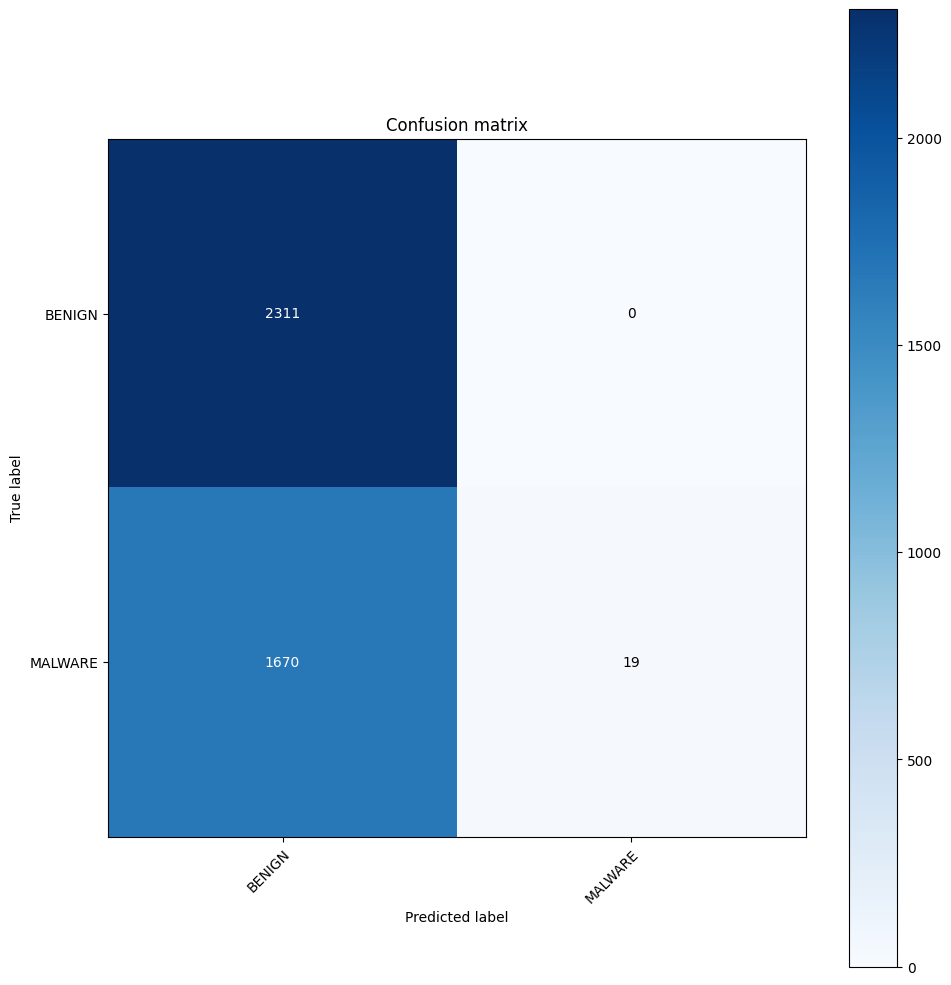

In [ ]:
# valuate models

for clf in models:
    # print scores 
    print(f'{clf.__class__.__name__}:')
    valuate(clf, X_test, y_test)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

      BENIGN       0.59      0.91      0.71     67991
     MALWARE       0.55      0.15      0.24     51410

    accuracy                           0.58    119401
   macro avg       0.57      0.53      0.47    119401
weighted avg       0.57      0.58      0.51    119401



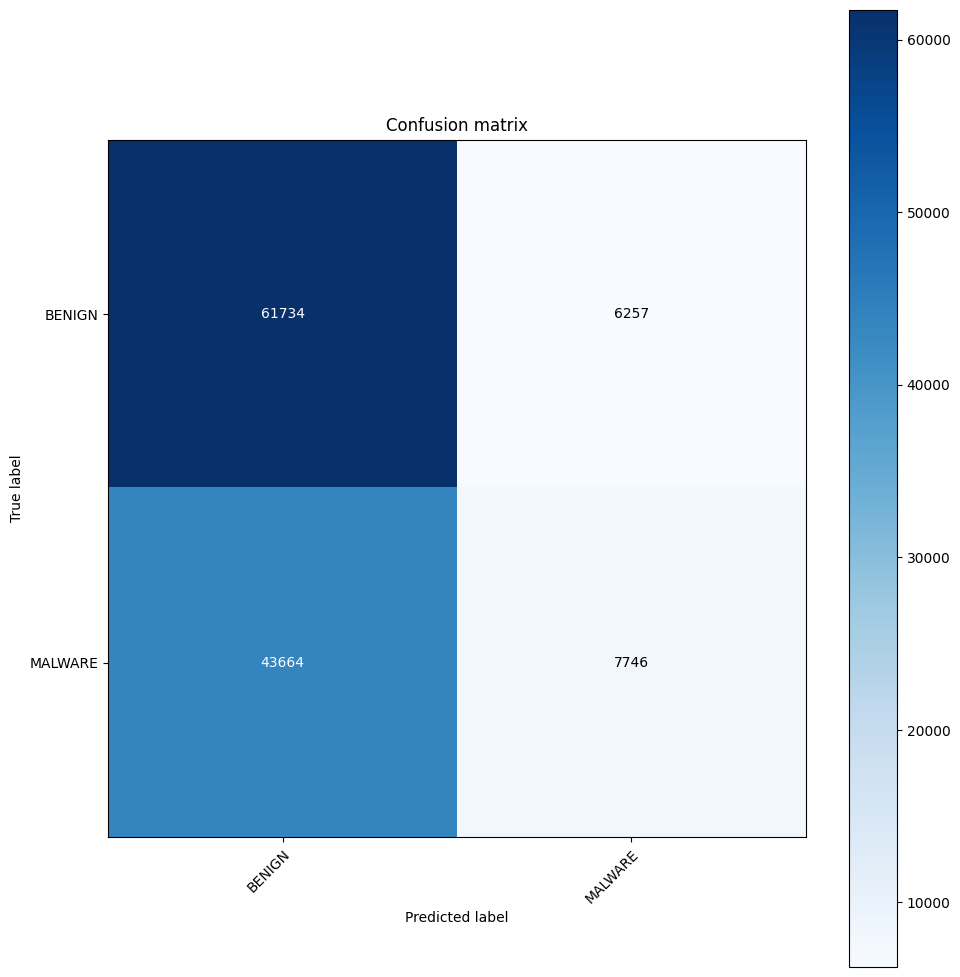

In [ ]:
valuate(logistic_classifier, X_test, y_test)

# Gaussian Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_classifier = LinearDiscriminantAnalysis().fit(X_train, y_train)

              precision    recall  f1-score   support

      BENIGN       0.59      0.89      0.71     67991
     MALWARE       0.58      0.19      0.29     51410

    accuracy                           0.59    119401
   macro avg       0.59      0.54      0.50    119401
weighted avg       0.59      0.59      0.53    119401



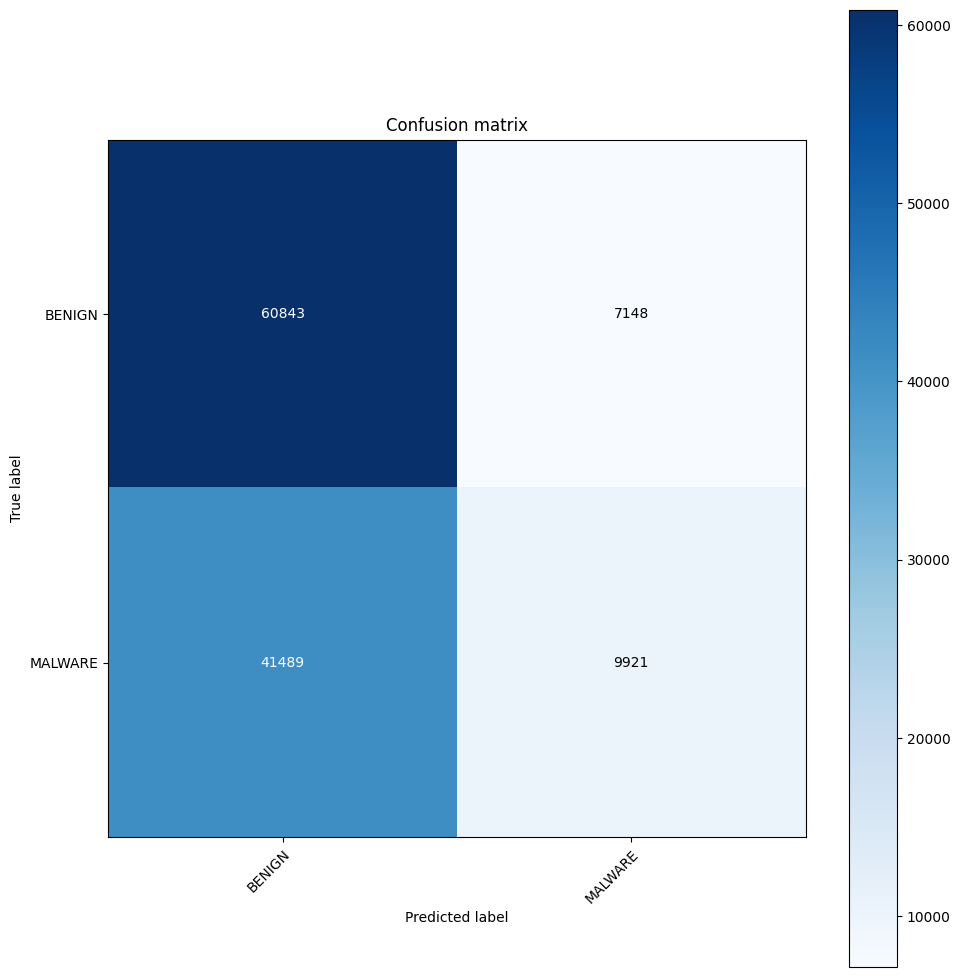

In [ ]:
valuate(lda_classifier, X_test, y_test)

# MultiLayer Perceptron

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    print("Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!")
    device = torch.device("cpu")

Using device: cpu


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class NetworkDataset(Dataset):
    def __init__(self, data, target):
        self.data = data.to_numpy()
        #self.data = data
        self.target = label_encoder.fit_transform(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]


train_dataset = NetworkDataset(X_train, y_train)
test_dataset = NetworkDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkNN(nn.Module):

    def __init__(self):
        super(NetworkNN, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 5)
        self.fc3 = nn.Linear(5, 2)
        self.logits = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.logits(x)
        return x

model = NetworkNN()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1} loss: {running_loss / len(dataloader)}')

In [ ]:
train(model, train_dataloader, criterion, optimizer, epochs=10)

Epoch 1 loss: 2.636086460457141
Epoch 2 loss: 0.688989948655674
Epoch 3 loss: 0.683590408668811
Epoch 4 loss: 0.6835964393641276
Epoch 5 loss: 0.6836031497951575
Epoch 6 loss: 0.6835981339546304
Epoch 7 loss: 0.6836013377202583
Epoch 8 loss: 0.6836016099552633
Epoch 9 loss: 0.683603422370882
Epoch 10 loss: 0.6836020034651706


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for _ in range(2))
class_total = list(0. for _ in range(2))

model.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.683236

Test Accuracy of     0: 100% (68091/68091)
Test Accuracy of     1:  0% ( 2/51310)

Test Accuracy (Overall): 57% (68093/119401)
